In [1]:
from IPython.display import HTML
from IPython.display import display

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Some hidden code... to show/hide this cell's raw code input, click (or double click if stubborn!) <a href="javascript:code_toggle()">here</a>.''')
display(tag)

############### Write code below ##################
from IPython.core.display import HTML
def css_styling():
    styles = open("./STUFF/colors.css", "r").read()
    return HTML(styles)
css_styling()

<div class=warn>
These blue boxes contain instructions for you to follow, or stuff for you to do
<h2>How to access this Jupyter notebook</h2>

* <b>Step 1</b>: Open a web browser, go to [this page](https://warwick.ac.uk/fac/sci/chemistry/research/maurer/maurergroup/software/iatl_strategic_project/), scroll down, download the Login App (the Windows exacutable if using ITS machines) and double click on the executable (usually ended up into the Download folder) <br>
* <b>Step 2</b>: The Notebook Launcher pops up: select the CH273 module and fill in the boxes using your SCRTP username and password <br>
* <b>Step 3</b>: Open the Jupyter notebook you are interested in, e.g. ```CW_1_Class.ipynb``` <br>
* <b>Step 4</b>: Make a copy of the orginal notebook (which is read only). In the toolbar on top of the notebook: File - Make a Copy <br>
* <b>Step 5</b>: You're all set! <br><br>
<b> Remember: </b> You can access this notebook at home at any time by going through the same steps on e.g. your laptop - all the changes you have made will be saved and synced! At the moment, though, you'll have to tunnel through the campus network via VPN (see [here](https://warwick.ac.uk/services/its/servicessupport/networkservices/vpn/))<br>
<div/>

# CH273: Computational Workshop 1
## The radial distribution function

In this session, we are going to play around with the radial distribution function, $g(r)$. As you may remember, the $g(r)$ represents the probability of finding a particle at a distance $r$ away from a given reference particle. Here, we are going to consider a hard sphere liquid, in two and three dimensions as well.

In [2]:
# Import a number is useful packages...
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import argrelextrema
from mpl_toolkits.mplot3d import Axes3D
from STUFF.poisson_disc import Grid
import random 

### The 2D case

In [3]:
# Set the length and width (the x and y dimensions) of the box
length = 10.0 # can be any units you like. A meaningful choice: [Å]
width = length # This is a square 2D box

# Set the minimum distance between the particles (as you can see, this is not really a hard sphere liquid! Why?)
min_r = 0.6 # [Å]rad_py

# Generate a random arrangement of particles - according to an algorithm called Poisson sampling.
# Note that every time you run this cell, the algorithm will generate a DIFFERENT configuration!
grid = Grid(min_r, length, width)
# Random seed 
rand = (random.uniform(0, length), random.uniform(0, width))
# Do the sampling
data = grid.poisson(rand)

<div class=warn>
Are we really considering a hard sphere liquid? Why? Write down your answer in a Markdown cell
<div/>

Not exactly. We are enforcing a minimum distance ```min_r > 0``` between the particles, which means that the potential goes from 0 to $\infty$ when the distance between two particles is ``` r < min_r```, not when the two particles actually overlap. However, we did not assign a radius to these particles: if you define the radius to be = 0.6, there you *do* have a hard sphere liquid!

### Define (and use) functions
Functions are bits of code we want to either re-use multiple times (today, or in a few years time...) or use to organise/clean-up our code/Notebook. Defining a function in Python is easy (see the example below). You just have to give it a name and to specifiy which arguments it will take as input, and what quantities you want as output. 

In [4]:
# We use "def" to tell Python we are defining a function

# "unzip" is the name of the function - I chose that. You can be creative, but long names are cumbersome to be called
# later on within the Notebook, and if the name of a function is the same as the name of a variable, things get ugly.
def unzip(items): # The list of arguments given as input is passed in the () brackets. In this case, "items"
                  # is the one and only argument required as input
    # We use "return" to tell Python this is the quantity we want to get as output anytime we call this function    
    return ([item[i] for item in items] for i in range(len(items[0])))

<div class=warn>
Define a function that takes as input argument an integer number $N$ and returns $N!$. Test whether your function is working!
<div/>

(From Wikipedia) The factorial of a non-negative integer n, denoted by n!, is the product of all positive integers less than or equal to n. For example,

$$5!=1x2x3x4x5=120$$

In [5]:
def factorial(n):
    ni=int(n) # convert the input into an integer
    fact_ni=1 #initialize your result
    for i in range(1,ni+1):
        print(i,fact_ni)
        fact_ni=fact_ni*i
    return fact_ni

In [6]:
factorial(16)

1 1
2 1
3 2
4 6
5 24
6 120
7 720
8 5040
9 40320
10 362880
11 3628800
12 39916800
13 479001600
14 6227020800
15 87178291200
16 1307674368000


20922789888000

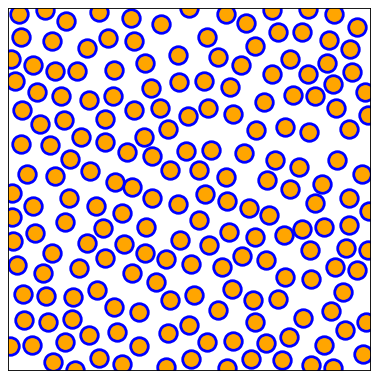

In [7]:
# Let's visualize the box and the particles - i.e. our hard sphere-ish liquid
plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(*unzip(data),s=250, facecolors='orange', edgecolors='blue',linewidth=2.5)
plt.tick_params(axis='both', which='both', length=0, labelleft=False, labelbottom=False)
plt.xlim(0,length)
plt.ylim(0,length)
plt.gca().set_aspect('equal', adjustable='box')
plt.rcParams["figure.figsize"] = (8,8)
plt.show()

### Calculating the g(r)
Now that we have a configuration, we can calculate the g(r), using the function "py_rdf" defined below. This function takes in input the following arguments: 
* **r**   = a numpy array containing the positions of all the particles
* **S**   = the length of the box (which is assumed to be square/cubic in 2/3D !!)
* **dr**  = the resolution in r. The smaller this value, the greater the resolution
* **dim** = the dimensionality of the system (2 or 3 D)

In [8]:
def py_rdf(r, S, dr, dim):
    from numpy import zeros, sqrt, where, pi, mean, arange, histogram, absolute
    num_particles  = len(r)
    rMax           = S/2.0;
    edges          = arange(0., rMax + dr, dr)
    num_increments = len(edges) - 1
    g              = zeros(num_increments)
    radii          = zeros(num_increments)
    numberDensity  = len(r) / S**dim

    # Compute pairwise correlation for each particle
    for index in range(num_particles):

        d = 0.0
        for i in range(dim):
            dp = absolute(r[index,i] - r[:,i])
            mask = dp>S/2.0
            dp[mask] = S - dp[mask]
            d += dp*dp

        d = sqrt(d)
        d[index] = 2 * rMax

        (result, bins) = histogram(d, bins=edges, density=False)
        g += result

    g = g/(num_particles * numberDensity)

    # Normalize the g(r) dividing by the g(r) of an ideal gas - in 2D!
    if dim == 2:
        for i in range(num_increments):
            radii[i] = (edges[i] + edges[i+1]) / 2.
            rOuter = edges[i + 1]
            rInner = edges[i]
            g[i] = g[i] / (2.0 * pi * (rOuter-rInner)* radii[i])
    
    # Needed to compute the 3D g(r) (blue box)
    # Normalize the g(r) divinding by the g(r) of an ideal gas - in 3D!
    if dim == 3:
        for i in range(num_increments):
            radii[i] = (edges[i] + edges[i+1]) / 2.
            rOuter = edges[i + 1]
            rInner = edges[i]
            g[i] = g[i] / (4.0 * pi * (rOuter-rInner)* radii[i] * radii[i] )

    return (radii, g)

Time to compute the g(r). We will *call* the py_rdf function we have just defined to do that. We will also interpolate the resulting points with a smooth function uscing the interp1d function from scipy

**Note**: in calculating the distances between the particles, we have to take into account the so-called periodic boundary conditions, which in turns implies that we can compute the g(r) only up to *half* the length of the box!

In [9]:
# Compute the g(r)
res_dr = 0.1 # resolution
n_data=np.array(data) # We store the atomic positions into a numpy array

# Call the py_rdf function. Note that the name of the arguments can be different, but not their order.
# For instance, we have called n_data the first argument, which is indicated as r in the definition
# of py_rdf above. Which is fine, Python will take care of that. But, we are not allowed to swap, say,
# n_data and length!!
rad_py, g_r_py = py_rdf(n_data, length, res_dr, 2)

# We interpolate the result to get a smooth line connecting the dots
res = 200 # How many points do we want in the interpolated line
safe = 1e-1 # Don't you worry about this one...

# We interpolate the g(r) using a cubic spline
f_cub = interp1d(rad_py, g_r_py, kind='cubic')
xnew = np.linspace(safe, (length/2.0)-safe, num=res, endpoint=True)

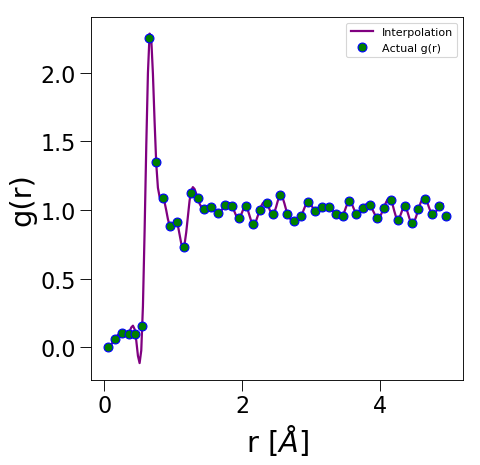

In [10]:
# Plot
plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.tick_params(axis='both', which='both', length=10.0, labelleft=True, labelbottom=True, labelsize=20.0)

# Interpolated g(r)
plt.plot(xnew, f_cub(xnew), color='purple', linestyle='solid', linewidth=2.0, label='Interpolation') 

# Actual g(r) points
plt.plot(rad_py, g_r_py, 'o', markerfacecolor='green', markersize=8, markeredgecolor='blue', 
         linewidth=2.5, label='Actual g(r)')

plt.legend()
plt.xlabel('r [$\AA$]', fontsize=26)
plt.ylabel('g(r)', fontsize=26)
plt.show()

In [11]:
# Needed for one of the blue boxes below...

# This may take a while, check the * in the [] on the left of the cell, when that's gone, you are good to go

n_confs=25 # Number of configurations we are going to take into account

g_r=np.zeros((len(g_r_py),n_confs))
g_r_ave=np.zeros(len(g_r_py))

n_ave=0
for i in range(0,n_confs):
    data = grid.poisson(rand)
    n_data=np.array(data)
    rad_py, g_r_py = py_rdf(n_data, length, res_dr, 2)
    g_r[:,i]=g_r_py
    n_ave=n_ave+len(n_data)

# Ensemble average of the g(r)
g_r_ave=(np.sum(g_r, axis=1))/n_confs

# Average number of particles
n_ave=n_ave/n_confs

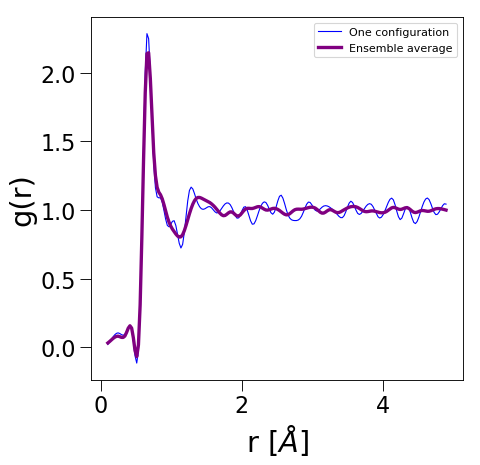

In [12]:
# Comparison of the g(r) for just one configuration and that obtained upon taking an ensemble average
f_cub_ave = interp1d(rad_py, g_r_ave, kind='cubic')
xnew = np.linspace(safe, (length/2.0)-safe, num=res, endpoint=True)
plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k') # figsize determine the actual size of the figure
plt.tick_params(axis='both', which='both', length=10.0, labelleft=True, labelbottom=True, labelsize=20.0)
plt.plot(xnew, f_cub(xnew), color='blue', linestyle='solid', linewidth=1.0, label='One configuration')
plt.plot(xnew, f_cub_ave(xnew), color='purple', linestyle='solid', linewidth=3.0, label='Ensemble average')
plt.xlabel('r [$\AA$]', fontsize=26)
plt.ylabel('g(r)', fontsize=26)
plt.legend()
plt.show()

In [13]:
# Integrate the g(r) to get the coordination number as a function of r || rad_py g_r_ave
d2dr=rad_py[1]-rad_py[0] # dr
density=n_ave/(length*length) # number density, 2D
cn_2d=np.zeros((len(rad_py),2))

for i in range(0,len(rad_py)):
    cn_2d[i,0]=rad_py[i]
    cn_2d[i,1]=cn_2d[i,1]+(g_r_ave[i]*rad_py[i]*d2dr)

cn_2d_highD=np.zeros((len(rad_py),2))
cn_2d_highD[:,0]=cn_2d[:,0]
cn_2d_highD[:,1]=cn_2d[:,1]*(2*np.pi*density)

### About the assessment
* Have a look at Moodle for up-to-date information
* The deadline for the submission of the assessed work is **12 January 2019**
* You will be required to submit a Jupyter Notebook
* Piece of cake

<div class=warn>
    
Compute the $g(r)$ for a configuration obtained by setting ```min_r = 1.2```. How does it look like, and why?
<div/>

In [14]:
# Set the minimum distance between the particles (as you can see, this is not really a hard sphere liquid! Why?)
min_r = 1.2 # [Å]rad_py

# Generate a random arrangement of particles - according to an algorithm called Poisson sampling.
# Note that every time you run this cell, the algorithm will generate a DIFFERENT configuration!
grid = Grid(min_r, length, width)
# Random seed 
rand = (random.uniform(0, length), random.uniform(0, width))
# Do the sampling
data = grid.poisson(rand)

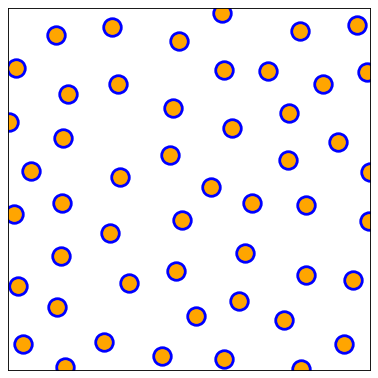

In [15]:
# Let's visualize the box and the particles - i.e. our hard sphere-ish liquid
plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(*unzip(data),s=250, facecolors='orange', edgecolors='blue',linewidth=2.5)
plt.tick_params(axis='both', which='both', length=0, labelleft=False, labelbottom=False)
plt.xlim(0,length)
plt.ylim(0,length)
plt.gca().set_aspect('equal', adjustable='box')
plt.rcParams["figure.figsize"] = (8,8)
plt.show()

In [16]:
# Compute the g(r)
res_dr = 0.1 # resolution
n_data=np.array(data) # We store the atomic positions into a numpy array

# Call the py_rdf function. Note that the name of the arguments can be different, but not their order.
# For instance, we have called n_data the first argument, which is indicated as r in the definition
# of py_rdf above. Which is fine, Python will take care of that. But, we are not allowed to swap, say,
# n_data and length!!
rad_py, g_r_py = py_rdf(n_data, length, res_dr, 2)

# We interpolate the result to get a smooth line connecting the dots
res = 200 # How many points do we want in the interpolated line
safe = 1e-1 # Don't you worry about this one...

# We interpolate the g(r) using a cubic spline
f_cub = interp1d(rad_py, g_r_py, kind='cubic')
xnew = np.linspace(safe, (length/2.0)-safe, num=res, endpoint=True)

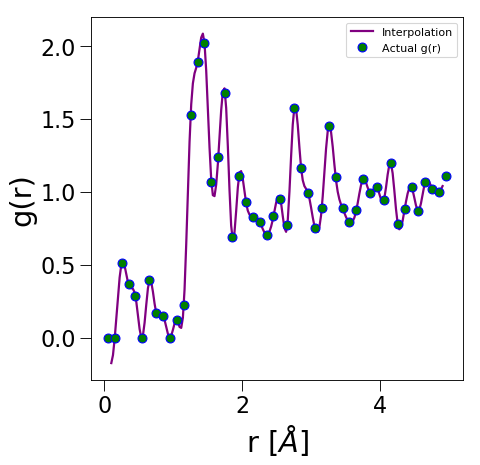

In [17]:
# Plot
plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.tick_params(axis='both', which='both', length=10.0, labelleft=True, labelbottom=True, labelsize=20.0)

# Interpolated g(r)
plt.plot(xnew, f_cub(xnew), color='purple', linestyle='solid', linewidth=2.0, label='Interpolation') 

# Actual g(r) points
plt.plot(rad_py, g_r_py, 'o', markerfacecolor='green', markersize=8, markeredgecolor='blue', 
         linewidth=2.5, label='Actual g(r)')

plt.legend()
plt.xlabel('r [$\AA$]', fontsize=26)
plt.ylabel('g(r)', fontsize=26)
plt.show()

* The main peak of the $g(r)$ corresponds to a large value of ```r``` if compared with the ```min_r = 0.6``` case.
* The $g(r)$ is very noisy/spiky
This makes sense, as a larger value of ```min_r``` leads to a lower density of particles, and thus to a longer average distance between them. In addition, you also have less particles, which makes for a more noisy $g(r)$

### The need for an ensemble average
As you can see, the g(r) looks a bit spiky. The reason? Well, we have considered just **one** configuration of our hard sphere liquid! We know that in order to get this right we need to perform an ensemble average, i.e. we have to average our g(r) over different configurations. How? We do a loop! Crucially, every time you call the grid.poisson function, you generate a different configuration - handy!

In [18]:
# This may take a while, check the * in the [] on the left of the cell, when that's gone, you are good to go

n_confs=25 # Number of configurations we are going to take into account

g_r=np.zeros((len(g_r_py),n_confs))
g_r_ave=np.zeros(len(g_r_py))

n_ave=0
for i in range(0,n_confs):
    data = grid.poisson(rand)
    n_data=np.array(data)
    rad_py, g_r_py = py_rdf(n_data, length, res_dr, 2)
    g_r[:,i]=g_r_py
    n_ave=n_ave+len(n_data)

# Ensemble average of the g(r)
g_r_ave=(np.sum(g_r, axis=1))/n_confs

# Average number of particles
n_ave=n_ave/n_confs

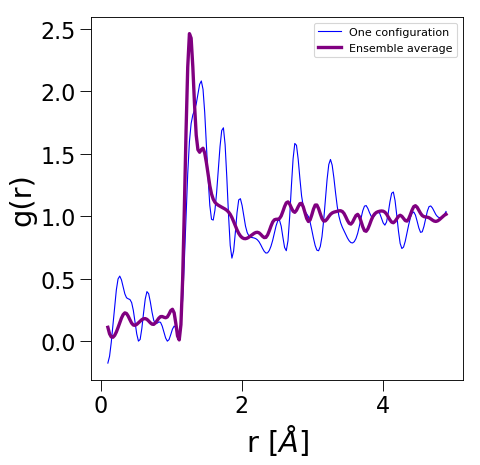

In [19]:
# Comparison of the g(r) for just one configuration and that obtained upon taking an ensemble average
f_cub_ave = interp1d(rad_py, g_r_ave, kind='cubic')
xnew = np.linspace(safe, (length/2.0)-safe, num=res, endpoint=True)
plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k') # figsize determine the actual size of the figure
plt.tick_params(axis='both', which='both', length=10.0, labelleft=True, labelbottom=True, labelsize=20.0)
plt.plot(xnew, f_cub(xnew), color='blue', linestyle='solid', linewidth=1.0, label='One configuration')
plt.plot(xnew, f_cub_ave(xnew), color='purple', linestyle='solid', linewidth=3.0, label='Ensemble average')
plt.xlabel('r [$\AA$]', fontsize=26)
plt.ylabel('g(r)', fontsize=26)
plt.legend()
plt.show()

### The coordination number
Now that we have our (ensemble averaged!) $g(r)$, we can compute the average coordination number $c_N$, which in two dimensions can be calculated from the $g(r)$ as follows: 

$$
c_N(r')_{2D} = 2\pi \int_0^{r'} g(r) r \rho  dr
$$

In [20]:
# Integrate the g(r) to get the coordination number as a function of r || rad_py g_r_ave
d2dr=rad_py[1]-rad_py[0] # dr
density=n_ave/(length*length) # number density, 2D
cn_2d=np.zeros((len(rad_py),2))

for i in range(0,len(rad_py)):
    cn_2d[i,0]=rad_py[i]
    cn_2d[i,1]=cn_2d[i,1]+(g_r_ave[i]*rad_py[i]*d2dr)

cn_2d[:,1]=cn_2d[:,1]*(2*np.pi*density)

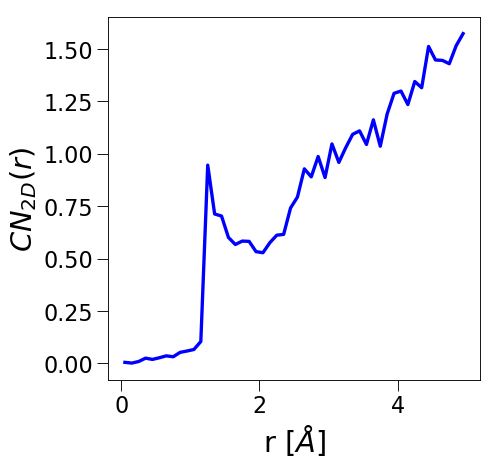

In [21]:
# Plot the coordination number as a function of r
plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.tick_params(axis='both', which='both', length=10.0, labelleft=True, labelbottom=True, labelsize=20.0)
plt.plot(cn_2d[:,0], cn_2d[:,1], color='blue', linestyle='solid', linewidth=3.0)
plt.xlabel('r [$\AA$]', fontsize=26)
plt.ylabel('$CN_{2D}(r)$', fontsize=26)
plt.show()

<div class=warn>
    
Compare the average coordination number for two hard sphere liquids obtained by setting ```min_r = 0.6``` and ```min_r = 1.2```
<div/>

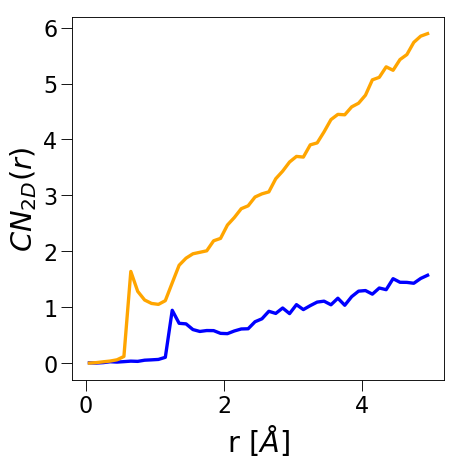

In [22]:
# As we dealt with the r_min=1.2 before, I have copy/pasted the relevant cells above - and defined
# a cn_2d_highD array containing the coordination number for the r_min=1.2 case

# Plot the coordination number as a function of r
plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.tick_params(axis='both', which='both', length=10.0, labelleft=True, labelbottom=True, labelsize=20.0)
plt.plot(cn_2d[:,0], cn_2d[:,1], color='blue', linestyle='solid', linewidth=3.0)
plt.plot(cn_2d_highD[:,0], cn_2d_highD[:,1], color='orange', linestyle='solid', linewidth=3.0)
plt.xlabel('r [$\AA$]', fontsize=26)
plt.ylabel('$CN_{2D}(r)$', fontsize=26)
plt.show()

In [23]:
# Integrate the g(r) to get the coordination number as a function of r || rad_py g_r_ave
d2dr=rad_py[1]-rad_py[0] # dr
density=n_ave/(length*length) # number density, 2D
cn_2d=np.zeros((len(rad_py),2))

for i in range(0,len(rad_py)):
    cn_2d[i,0]=rad_py[i]
    cn_2d[i,1]=cn_2d[i,1]+(g_r_ave[i]*rad_py[i]*d2dr)

cn_2d[:,1]=cn_2d[:,1]*(2*np.pi*density)

### The 3D case

In [24]:
tdr=0.5 # r is the minimum radius between points
tdlength = 4.0 # length and width are rectangular bounds
tdwidth = tdlength
tdheight = tdwidth
grid = Grid(tdr, tdlength, tdwidth, tdheight)
rand = (random.uniform(0, tdlength), random.uniform(0, tdwidth), random.uniform(0, tdheight))
tddata = grid.poisson(rand, 30)

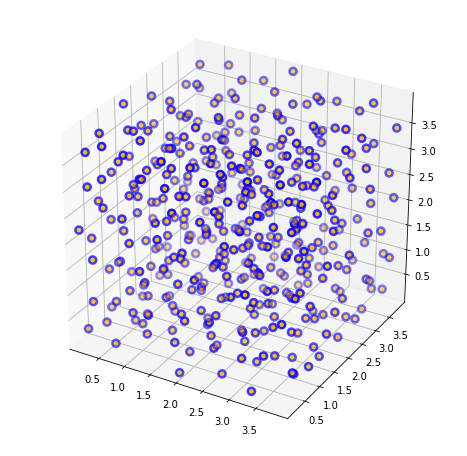

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*unzip(tddata),s=50, facecolors='orange', edgecolors='blue',linewidth=2.5)
ax.margins(0,0,0)

<div class=warn>

* Compute the $g(r)$. Note that in order to normalize it correctly, you will have to modify the ```py_rdf``` function to take into account the three dimensional case. In particular, the $g(r)$ will have to be normalized by:

$$
r^2 4.0\pi dr 
$$

* $c_N$, which in three dimensions can be calculated from the $g(r)$ as follows: 

$$
c_N(r')_{3D} = 4\pi \int_0^{r'} g(r) r^2 \rho  dr
$$
<div/>

In [26]:
# Compute self-pair correlation
tddr=0.05
td_data=np.array(tddata)
tdrad, tdg_r = py_rdf(td_data, tdlength, tddr, 3)
tdf = interp1d(tdrad, tdg_r, kind='cubic')
tdx = np.linspace(safe, (tdlength/2.0)-safe, num=res, endpoint=True)

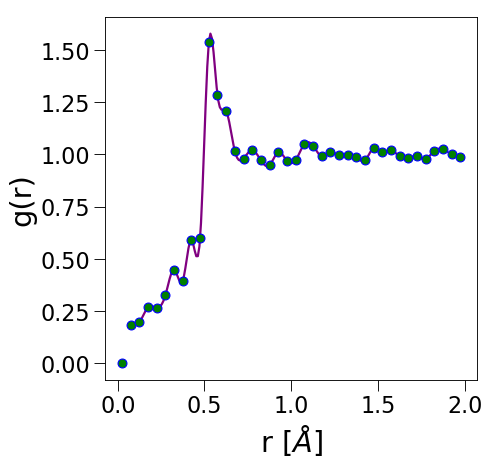

In [27]:
plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.tick_params(axis='both', which='both', length=10.0, labelleft=True, labelbottom=True, labelsize=20.0)
plt.plot(tdx, tdf(tdx), color='purple', linestyle='solid', linewidth=2.0)
plt.plot(tdrad, tdg_r, 'o', markerfacecolor='green', markersize=8, markeredgecolor='blue', linewidth=2.5)
plt.xlabel('r [$\AA$]', fontsize=26)
plt.ylabel('g(r)', fontsize=26)
plt.show()

In [28]:
# Integrate the g(r) to get the coordination number as a function of r
delta_r=tdrad[1]-tdrad[0]
td_n=len(td_data)
td_density=td_n/(tdlength*tdlength*tdlength) # number density, 3D
cn_3d=np.zeros((len(tdrad),2))

for i in range(0,len(tdrad)):
    cn_3d[i,0]=tdrad[i]
    cn_3d[i,1]=cn_3d[i,1]+(tdg_r[i]*tdrad[i]*tdrad[i]*delta_r)

cn_3d[:,1]=cn_3d[:,1]*(4*np.pi*density)

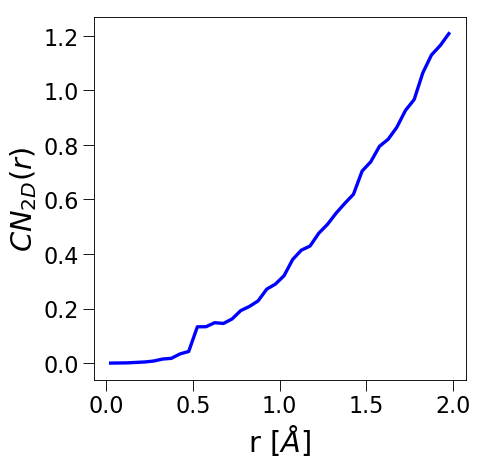

In [29]:
# Plot the coordination number as a function of r
plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.tick_params(axis='both', which='both', length=10.0, labelleft=True, labelbottom=True, labelsize=20.0)
plt.plot(cn_3d[:,0], cn_3d[:,1], color='blue', linestyle='solid', linewidth=3.0)
plt.xlabel('r [$\AA$]', fontsize=26)
plt.ylabel('$CN_{2D}(r)$', fontsize=26)
plt.show()